In [2]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
class tb_helper_offline():
    def __init__(self, scalars, path, batch_train_count=0, batch_val_count=0):
        self.path = path
        self.scalars = {key: np.zeros(scalars[key]) for key in scalars}

        self.custom_fn = False
        self.batch_train_count = batch_train_count
        self.batch_val_count = batch_val_count

    def write_scalars(self, entry):
        for scalar_entry in entry:
            key, val, batch = scalar_entry
            if key in self.scalars:
                self.scalars[key][batch] = val

    def set_batch_train_count(self, batch_train_count):
        self.batch_train_count = batch_train_count

    def set_batch_val_count(self, batch_val_count):
        self.batch_val_count = batch_val_count

    def save(self):
        for key in self.scalars:
            np.save(self.path + key + '.npy', self.scalars[key])

    def load(self):
        for key in self.scalars:
            self.scalars[key] = np.load(self.path + key + '.npy')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
model_path = './top_landscape/models/'
data_path = "./top_landscape/data/"

data_config = "./top_landscape/particle_transformer/data/TopLandscape/top_kin.yaml"
model_config = "./top_landscape/particle_transformer/networks/example_ParticleNet.py"

log_path = './top_landscape/logs/'

In [6]:
class empty():
    def __init__(self):
        pass

project = empty()
project.data_train = [data_path + '/train_file.parquet']
table = _read_parquet(project.data_train, {'label'})
project.len_data_train = len(table)
del table

project.data_val = [data_path + '/val_file.parquet']
project.data_test = [data_path + '/test_file.parquet']
project.data_config = data_config
project.network_config = model_config
project.num_workers = 1
project.fetch_step = 1
project.in_memory = True
project.batch_size = 512
project.samples_per_epoch = 2400*project.batch_size #2400
project.samples_per_epoch_val = 800*project.batch_size #800
project.num_epochs = 60
project.gpus = 0
project.start_lr = 1e-2
project.optimizer = "adam" 
project.log = log_path + '/ParticleNet_Test.log'
project.predict = False
project.predict_output = ''

project.regression_mode = False
project.extra_selection = None
project.extra_test_selection = None
project.data_fraction = 1
project.file_fraction = 1
project.fetch_by_files = False
project.train_val_split = 0.8
project.no_remake_weights = False
project.demo = False
project.lr_finder = None
project.tensorboard = None
project.tensorboard_custom_fn = None
project.network_option = []
project.load_model_weights = None
project.exclude_model_weights = None
project.steps_per_epoch = None
project.steps_per_epoch_val = None
project.optimizer_option = [('betas', '(0.99, 0.99)')]
project.lr_scheduler = "flat"#"flat+decay"
project.warmup_steps = 0
project.load_epoch = None
project.use_amp = False
project.predict_gpus = None
project.export_onnx = None
project.export_opset = 15
project.io_test = False
project.copy_inputs = False
project.print = False
project.profile = False
project.backend = None
project.cross_validation = None

project.local_rank = None if project.backend is None else int(os.environ.get("LOCAL_RANK", "0"))

project.model_prefix = mkdir(model_path + f'/ParticleNet_{project.optimizer}_lr{project.start_lr}_opt{project.optimizer_option}/')

if project.samples_per_epoch is not None:
    if project.steps_per_epoch is None:
        project.steps_per_epoch = project.samples_per_epoch // project.batch_size
    else:
        raise RuntimeError('Please use either `--steps-per-epoch` or `--samples-per-epoch`, but not both!')

if project.samples_per_epoch_val is not None:
    if project.steps_per_epoch_val is None:
        project.steps_per_epoch_val = project.samples_per_epoch_val // project.batch_size
    else:
        raise RuntimeError('Please use either `--steps-per-epoch-val` or `--samples-per-epoch-val`, but not both!')

if project.steps_per_epoch_val is None and project.steps_per_epoch is not None:
    project.steps_per_epoch_val = round(project.steps_per_epoch * (1 - project.train_val_split) / project.train_val_split)
if project.steps_per_epoch_val is not None and project.steps_per_epoch_val < 0:
    project.steps_per_epoch_val = None

if not "Acc" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Acc/")
if not "Loss" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Loss/")


In [7]:
project.len_data_train

1210999

In [8]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(project)
model, model_info, loss_func = model_setup(project, data_config, device=device)
model = model.to(device)
model.load_state_dict(torch.load('./models/base_model.pt'))

opt, scheduler = optim(project, model, device)

In [9]:
print(f"initiated model with {sum(p.numel() for p in model.parameters())} parameters")

initiated model with 366160 parameters


In [10]:
offline_tb = tb_helper_offline({"Loss/train":  project.steps_per_epoch*project.num_epochs+1, 
                                "Acc/train":  project.steps_per_epoch*project.num_epochs+1}, 
                                project.model_prefix)

In [11]:
from MCMC_weaver_utils import train_classification as train
from weaver.utils.nn.tools import evaluate_classification as evaluate
import shutil

load = True
if not load:
    best_valid_metric = np.inf if project.regression_mode else 0
    grad_scaler = torch.cuda.amp.GradScaler() if project.use_amp else None
    for epoch in range(project.num_epochs):
        if project.load_epoch is not None:
            if epoch <= project.load_epoch:
                continue

        train(model, loss_func, opt, scheduler, train_loader, device, epoch,
            steps_per_epoch=project.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=offline_tb)
        
        if project.model_prefix and (project.backend is None or project.local_rank == 0):
            dirname = os.path.dirname(project.model_prefix)
            if dirname and not os.path.exists(dirname):
                os.makedirs(dirname)
            state_dict = model.module.state_dict() if isinstance(
                model, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model.state_dict()
            torch.save(state_dict, project.model_prefix + '_epoch-%d_state.pt' % epoch)
            torch.save(opt.state_dict(), project.model_prefix + '_epoch-%d_optimizer.pt' % epoch)

        valid_metric = evaluate(model, val_loader, device, epoch, loss_func=loss_func,
                                steps_per_epoch=project.steps_per_epoch_val)
        is_best_epoch = (
            valid_metric < best_valid_metric) if project.regression_mode else(
            valid_metric > best_valid_metric)
        if is_best_epoch:
            best_valid_metric = valid_metric
            if project.model_prefix and (project.backend is None or project.local_rank == 0):
                shutil.copy2(project.model_prefix + '_epoch-%d_state.pt' %
                            epoch, project.model_prefix + '_best_epoch_state.pt')
                # torch.save(model, args.model_prefix + '_best_epoch_full.pt')
        print('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
                    (epoch, valid_metric, best_valid_metric))

        offline_tb.save()
else:
    offline_tb.load()

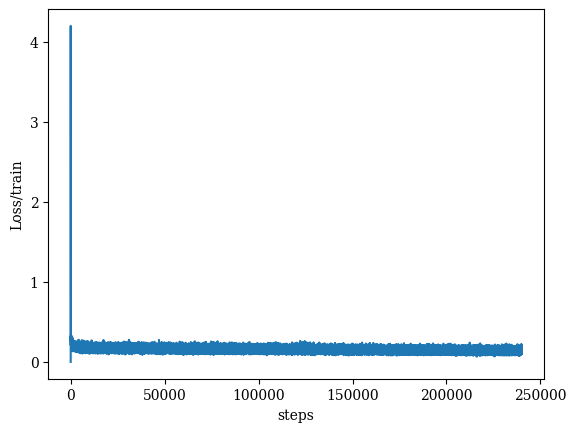

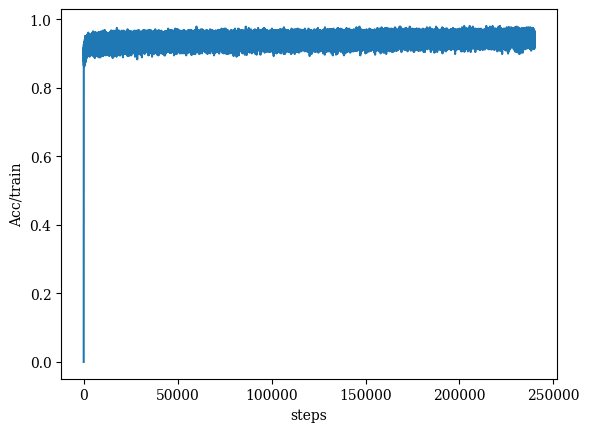

In [12]:
for key in offline_tb.scalars:
    plt.plot(offline_tb.scalars[key])
    plt.xlabel('steps')
    plt.ylabel(key)
    plt.show()

#offline_tb.save()

In [14]:
from weaver.utils.nn.tools import _flatten_preds, _logger, Counter

import sys
sys.path.append('../..')
from src.MCMC_Adam import MCMC_by_bp as AdamMCMC

import time
import tqdm

import cProfile, pstats, io
from pstats import SortKey

def train_classification_MCMC(
        model, loss_func, MCMC, scheduler, train_loader, dev, epoch, steps_per_epoch=None, grad_scaler=None,
        tb_helper=None, loop_kwargs={}):
    model.train()

    data_config = train_loader.dataset.config

    label_counter = Counter()
    total_loss = 0
    num_batches = 0
    total_correct = 0
    entry_count = 0
    count = 0
    start_time = time.time()

    maxed_out_mbb_batches  = 0

    with tqdm.tqdm(train_loader) as tq:
        for X, y, _ in tq:
            inputs = [X[k].to(dev) for k in data_config.input_names]
            label = y[data_config.label_names[0]].long().to(dev)
            entry_count += label.shape[0]
            try:
                mask = y[data_config.label_names[0] + '_mask'].bool().to(dev)
            except KeyError:
                mask = None
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
                model_output = model(*inputs)
                logits, label, _ = _flatten_preds(model_output, label=label, mask=mask)
                loss = loss_func(logits, label)

            loss_fct_mcmc = lambda: loss_func(_flatten_preds(model(*inputs), label=label, mask=mask)[0], label)
            
            t1 = time.time()
            _,a,b,_,_ = MCMC.step(loss_fct_mcmc, **loop_kwargs)
            t2 = time.time()
            print('total time: ', t2-t1)

            if b: 
                maxed_out_mbb_batches  = 0
            if maxed_out_mbb_batches > 100:
                print('MBB sampling is not convergent, reinitializing the chain')
                MCMC.start = True #This is a hot fix to not get the optimizer stuck to often

            if scheduler and getattr(scheduler, '_update_per_step', False):
                scheduler.step()
            if scheduler.get_last_lr()[0] <= getattr(scheduler, 'min_lr', 0):
                scheduler._update_per_step = False

            _, preds = logits.max(1)
            loss = loss.item()
                
            num_examples = label.shape[0]
            label_counter.update(label.numpy(force=True))
            num_batches += 1
            count += num_examples
            correct = (preds == label).sum().item()
            total_loss += loss
            total_correct += correct

            tq.set_postfix({
                'lr': '%.2e' % scheduler.get_last_lr()[0] if scheduler else opt.defaults['lr'],
                'Loss': '%.5f' % loss,
                'AvgLoss': '%.5f' % (total_loss / num_batches),
                'Acc': '%.5f' % (correct / num_examples),
                'AvgAcc': '%.5f' % (total_correct / count)})

            if tb_helper:
                tb_helper.write_scalars([
                    ("Loss/train", loss, tb_helper.batch_train_count + num_batches),
                    ("Acc/train", correct / num_examples, tb_helper.batch_train_count + num_batches),
                    ('Acceptance_rate', a, tb_helper.batch_train_count + num_batches),
                    ('lr', '%.2e' % scheduler.get_last_lr()[0] if scheduler else opt.defaults['lr'], tb_helper.batch_train_count + num_batches),
                ])
                if tb_helper.custom_fn:
                    with torch.no_grad():
                        tb_helper.custom_fn(model_output=model_output, model=model,
                                            epoch=epoch, i_batch=num_batches, mode='train')

            if steps_per_epoch is not None and num_batches >= steps_per_epoch:
                break

    time_diff = time.time() - start_time
    _logger.info('Processed %d entries in total (avg. speed %.1f entries/s)' % (entry_count, entry_count / time_diff))
    _logger.info('Train AvgLoss: %.5f, AvgAcc: %.5f' % (total_loss / num_batches, total_correct / count))
    _logger.info('Train class distribution: \n    %s', str(sorted(label_counter.items())))

    if tb_helper:
        tb_helper.write_scalars([
            ("Loss/train (epoch)", total_loss / num_batches, epoch),
            ("Acc/train (epoch)", total_correct / count, epoch),
        ])
        if tb_helper.custom_fn:
            with torch.no_grad():
                tb_helper.custom_fn(model_output=model_output, model=model, epoch=epoch, i_batch=-1, mode='train')
        # update the batch state
        tb_helper.batch_train_count += num_batches

    if scheduler and not getattr(scheduler, '_update_per_step', False):
        scheduler.step()


In [15]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(project)
project_2 = dc(project)
project_2.batch_size = 1024*2 #2**12
project_2.in_memory = False
project_2.steps_per_epoch = None
train_loader_full,_,_,_,_ = train_load(project_2)

model_MCMC, model_info_MCMC, loss_func_MCMC = model_setup(project, data_config, device=device)
model_MCMC = model_MCMC.to(device)
model_MCMC.device = device
model_MCMC.load_state_dict(torch.load('./models/base_model.pt'))

lr = 0.001 #5e-6
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
sigma = 0.2
optim_str = 'Adam'
betas_adam = (0.99,0.99)

from weaver.utils.nn.tools import _flatten_preds
def loss_fct_mcmc_full(model):
    # this is just some quick function to iterate over the full dataloader to calculate the full loss. I know it is not the nicest style to use globally defined variables in a function etc.
    with torch.no_grad():
        full_loss = 0
        for i_batch, (X, y, _ )in enumerate(train_loader_full):
                print(f'{i_batch}/{project_2.len_data_train//project_2.batch_size} if the full loss loop', end = '\r')
                inputs = [X[k].to(device) for k in data_config.input_names]
                label = y[data_config.label_names[0]].long().to(device)
                count = label.shape[0]
                try:
                    mask = y[data_config.label_names[0] + '_mask'].bool().to(device)
                except KeyError:
                    mask = None
                model_output = model(*inputs)
                logits, label, _ = _flatten_preds(model_output, label=label, mask=mask)
                full_loss += loss_func_MCMC(logits, label)*count
        del model_output, inputs, label
    return full_loss

loop_kwargs = {
             'MH': True, #this is a little more than x2 runtime
             'verbose': False,
             'fixed_batches': True,
             'sigma_adam_dir': 0, #sum(p.numel() for p in model_MCMC.parameters())/100, 
             'sigma_factor': 1,
             'extended_doc_dict': False,
             'full_loss': None,#loss_fct_mcmc_full 
}

if optim_str == 'Adam':
    optim = torch.optim.Adam(model_MCMC.parameters(), lr=lr, betas=betas_adam)
    optim_str += f'betas{betas_adam}'
elif optim_str == 'SGD':
    optim = torch.optim.SGD(model_MCMC.parameters(), lr=lr)
else:
    try: 
        optim = getattr(torch.optim, optim_str)(lr = lr)
    except:
        raise Exception(f'{optim_str} is not a valid optimizer')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)

project.model_prefix = mkdir(model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{loop_kwargs["sigma_adam_dir"]}_sigmafactor{loop_kwargs["sigma_factor"]}/')
if not "Acc" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Acc/")
if not "Loss" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Loss/")
project.log = log_path + '/ParticleNet_Test_MCMC.log'


scheduler._update_per_step = True
scheduler.min_lr = min_lr

MCMC = AdamMCMC(model_MCMC, optim, temp, sigma)

In [16]:
print(f"initiated model with {sum(p.numel() for p in model_MCMC.parameters())} parameters")

initiated model with 366160 parameters


In [17]:
offline_tb_MCMC = tb_helper_offline({"Loss/train":  project.steps_per_epoch*project.num_epochs+1, 
                                    "Acc/train":  project.steps_per_epoch*project.num_epochs+1,
                                    "Acceptance_rate": project.steps_per_epoch*project.num_epochs+1,
                                    "lr": project.steps_per_epoch*project.num_epochs+1}, 
                                    project.model_prefix)

In [18]:
from weaver.utils.nn.tools import train_classification as train
from weaver.utils.nn.tools import evaluate_classification as evaluate
import shutil

load = True
if not load:
    best_valid_metric = np.inf if project.regression_mode else 0
    grad_scaler = torch.cuda.amp.GradScaler() if project.use_amp else None
    for epoch in range(project.num_epochs):
        if project.load_epoch is not None:
            if epoch <= project.load_epoch:
                continue

        train_classification_MCMC(model_MCMC, loss_func_MCMC, MCMC, scheduler, train_loader, device, epoch,
            steps_per_epoch=project.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=offline_tb_MCMC, loop_kwargs = loop_kwargs)
        
        if project.model_prefix and (project.backend is None or project.local_rank == 0):
            dirname = os.path.dirname(project.model_prefix)
            if dirname and not os.path.exists(dirname):
                os.makedirs(dirname)
            state_dict = model_MCMC.module.state_dict() if isinstance(
                model_MCMC, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model_MCMC.state_dict()
            torch.save(state_dict, project.model_prefix + '_epoch-%d_state.pt' % epoch)
            torch.save(opt.state_dict(), project.model_prefix + '_epoch-%d_optimizer.pt' % epoch)

    # valid_metric = evaluate(model_MCMC, val_loader, device, epoch, loss_func=loss_func,
    #                         steps_per_epoch=project.steps_per_epoch_val)
    # is_best_epoch = (
    #     valid_metric < best_valid_metric) if project.regression_mode else(
    #     valid_metric > best_valid_metric)
    # if is_best_epoch:
    #     best_valid_metric = valid_metric
    #     if project.model_prefix and (project.backend is None or project.local_rank == 0):
    #         shutil.copy2(project.model_prefix + '_epoch-%d_state.pt' %
    #                     epoch, project.model_prefix + '_best_epoch_state.pt')
    #         # torch.save(model, args.model_prefix + '_best_epoch_full.pt') 
    # print('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
    #             (epoch, valid_metric, best_valid_metric))

        offline_tb_MCMC.save()
else:
    offline_tb_MCMC.load()

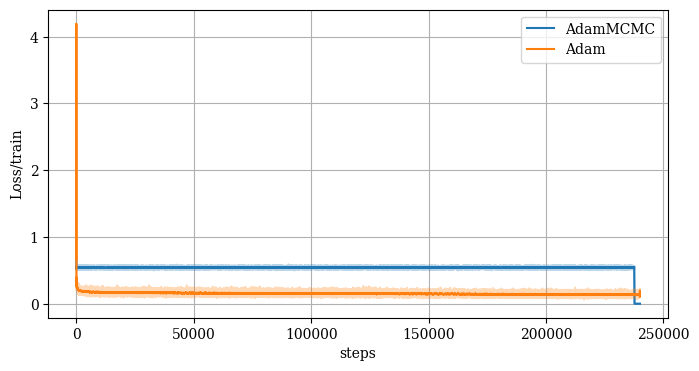

<Figure size 640x480 with 0 Axes>

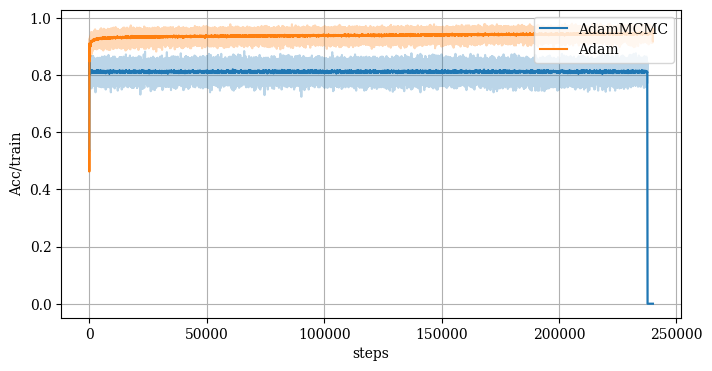

<Figure size 640x480 with 0 Axes>

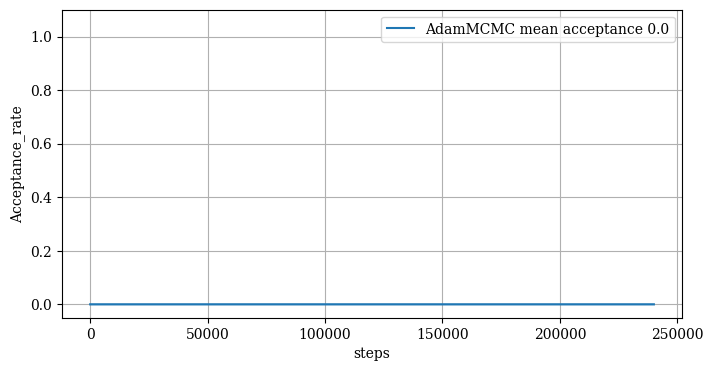

<Figure size 640x480 with 0 Axes>

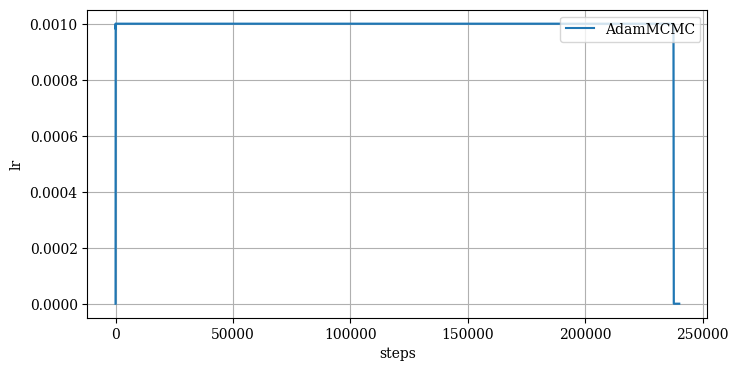

<Figure size 640x480 with 0 Axes>

In [19]:
for key in offline_tb_MCMC.scalars:
    plt.figure(figsize=(8,4))
    s = 1001 if key == "Acceptance_rate" else 101
    len_MCMC = len(offline_tb_MCMC.scalars[key][1:])
    if key == "Acceptance_rate":
        plt.plot(offline_tb_MCMC.scalars[key][1:], alpha = 0.3, color = 'C0')
        plt.plot(smooth(np.clip(offline_tb_MCMC.scalars[key], 0, 1), s)[1:-1], label = f"AdamMCMC mean acceptance {np.mean(np.clip(offline_tb_MCMC.scalars[key], 0, 1)):3.2}", color = 'C0')

        plt.ylim(-0.05, 1.1)
    else:
        plt.plot(smooth(offline_tb_MCMC.scalars[key][:len_MCMC], s)[1:], label = "AdamMCMC", color = 'C0')
        plt.plot(offline_tb_MCMC.scalars[key][1:][:len_MCMC], alpha = 0.3, color = 'C0')

        if key in offline_tb.scalars:
            plt.plot(smooth(offline_tb.scalars[key][:len_MCMC], s)[1:], label = "Adam", color = 'C1')
            plt.plot(offline_tb.scalars[key][1:][:len_MCMC], alpha = 0.3, color = 'C1')

    plt.xlabel('steps')
    plt.ylabel(key)
    #plt.xlim(0,240_000)
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.show()
    plt.savefig(project.model_prefix+key+'.pdf')


# Evalutation Snippets

In [20]:
from weaver.utils.nn.tools import _flatten_preds

def get_logits_and_labels(model, project, test_loaders = None, data_config = None):
    if test_loaders is None or data_config is None:
        test_loaders, data_config = test_load(project)
    for _, get_test_loader in test_loaders.items():
        test_loader = get_test_loader()
        continue

    logits_list = []
    label_list = []

    with torch.no_grad():
        with tqdm.tqdm(test_loader) as tq:
            for X, y, Z in tq:
                # X, y: torch.Tensor; Z: ak.Array
                inputs = [X[k].to(device) for k in data_config.input_names]
                label = y[data_config.label_names[0]].long().to(device)
                try:
                    mask = y[data_config.label_names[0] + '_mask'].bool().to(device)
                except KeyError:
                    mask = None
                model_output = model(*inputs)
                logits, label, mask = _flatten_preds(model_output, label=label, mask=mask)

                #_, preds = logits.max(1)

                logits_list.append(logits)
                label_list.append(label)

    logits = torch.cat(logits_list)
    label = torch.cat(label_list)

    return logits, label, test_loaders, data_config

In [67]:
n_epochs = 41
n_samples = 10
project.start_lr = 0.001

for beta in [0.99]: #[0.999,0.99,0.9,0.5,0.1]: 
    project.optimizer_option = [('betas', f'({beta}, {beta})')]
    offline_tb.path = model_path + f'/ParticleNet_{project.optimizer}_lr{project.start_lr}_opt{project.optimizer_option}/'

    if "adam_pred_entropy.npy" in os.listdir(offline_tb.path):
        adam_pred_entropy = np.load(offline_tb.path +"adam_pred_entropy.npy")
        print('loaded: ' + offline_tb.path +"adam_pred_entropy.npy")
    else:
        model.load_state_dict(torch.load(offline_tb.path + f'_epoch-{n_epochs-1}_state.pt'))
        logits, labels, _, _ = get_logits_and_labels(model, project)
        scores = torch.softmax(logits.float(), dim=1).numpy(force=True)+1e-10
        labels = labels.numpy(force=True)

        _, preds = logits.max(1)
        np.save(offline_tb.path +"preds.npy", preds.numpy(force=True))
        np.save(offline_tb.path +"labels.npy", labels)
        np.save(offline_tb.path +"logits.npy", logits.numpy(force=True))

        adam_pred_entropy = -np.sum(np.nan_to_num(scores*np.log(scores)), 1)
        np.save(offline_tb.path +"adam_pred_entropy.npy", adam_pred_entropy)

0it [00:00, ?it/s]

=== Restarting DataIter test__worker0, seed=2809470196 ===


790it [03:29,  3.77it/s]


In [22]:
# n_epochs = 50
# n_samples = 10
# test_loaders, data_config = None, None

# for i_sg, sigma_adam_dir_denom in enumerate(sigma_adam_dir_denoms):
#     sigma_adam_dir =  sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

#     path_tmp = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'

#     if not "post_pred_entropy.npy" in os.listdir(path_tmp):
#         for epoch in range(n_epochs-n_samples, n_epochs):
#             model.load_state_dict(torch.load(path_tmp + f'_epoch-{epoch}_state.pt'))

#             logits, labels, test_loaders, data_config = get_logits_and_labels(model, project, test_loaders, data_config)

#             if epoch == n_epochs-n_samples:
#                 logits_out = logits.unsqueeze(-1)
#             else:
#                 logits_out = torch.cat([logits_out, logits.unsqueeze(-1)], -1)

#         _, preds = torch.mean(logits_out, -1).max(1)
#         np.save(path_tmp +"preds.npy", preds.numpy(force=True))
#         np.save(path_tmp +"labels.npy", labels.numpy(force=True))

#         scores = torch.softmax(logits_out.float(), dim=1).numpy(force=True)+1e-10
#         post_pred = np.mean(scores, -1)
#         post_pred_entropy = -np.sum(post_pred*np.log(post_pred), 1)
#         np.save(path_tmp +"post_pred_entropy.npy", post_pred_entropy)

#         entropy_expect = np.mean(-np.sum(scores*np.log(scores), 1), -1)
#         np.save(path_tmp +"entropy_expect.npy", entropy_expect)

#         mutual_info = post_pred_entropy - entropy_expect
#         np.save(path_tmp +"mutual_info.npy", mutual_info)


# The Plot with all the Acceptances and Accuracies

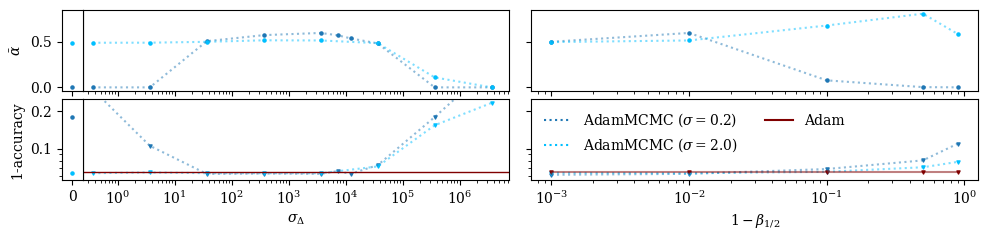

In [21]:
fig_accept_all, ax_accept_all = plt.subplots(2,2, figsize = (10,2.5), sharey= 'row', sharex = 'col')

ax_accept = ax_accept_all[0,:]
ax_accu = ax_accept_all[1,:]

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax_accept[0])
ax_0 = divider.append_axes("left", size="5%", pad=0, sharey=ax_accept[0])

divider = make_axes_locatable(ax_accu[0])
ax_1 = divider.append_axes("left", size="5%", pad=0, sharey=ax_accu[0])

lr = 1e-3
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
sigmas = [0.2,2.0] #2.0 
sigma_colors = ["C0", "deepskyblue"]

#############################
### sigma_adam_dir_denoms ###
#############################

sigma_factor = 1
betas_adam = (0.99,0.99)

optim_str = 'Adam'
optim_str += f'betas{betas_adam}'
color_adam = 'maroon'

n_params = sum(p.numel() for p in model_MCMC.parameters())

for i_nsg, sigma in enumerate(sigmas):
    sigma_adam_dir_denoms = None
    if sigma == 2.:
        sigma_adam_dir_denoms = np.array([1e6, 1e5, 10000, 1000, 100, 10, 1, 0.1])    
    elif sigma == 0.2:
        sigma_adam_dir_denoms = np.array([1e6, 1e5, 10000, 1000, 100, 50, 30, 10, 1, 0.1]) 

    accept, accu_test = np.zeros(len(sigma_adam_dir_denoms)), np.zeros(len(sigma_adam_dir_denoms))

    for i_sg, sigma_adam_dir_denom in enumerate(sigma_adam_dir_denoms):
        sigma_adam_dir = sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

        offline_tb_temp = tb_helper_offline({"Acceptance_rate": project.steps_per_epoch*project.num_epochs+1},
                                            model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/')
        offline_tb_temp.load()

        accept[i_sg] = np.mean(np.clip(offline_tb_temp.scalars["Acceptance_rate"], 0, 1))

        path = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
        preds = np.load(path +"preds.npy")
        labels = np.load(path +"labels.npy")
        correct = (preds == labels).sum().item()

        accu_test[i_sg] = correct/len(preds)

    x = n_params/sigma_adam_dir_denoms
    ax_accept[0].scatter(x, accept, s=5, label = r'$\sigma = $' + f'{sigma}', color = sigma_colors[i_nsg])
    ax_accept[0].plot(x, accept, linestyle = ':', alpha = 0.5, color = sigma_colors[i_nsg])

    ax_accu[0].scatter(x, 1-accu_test, color = sigma_colors[i_nsg], marker = 'v',  s=5, label = r'$\sigma = $' + f'{sigma}')
    ax_accu[0].plot(x, 1-accu_test, alpha = 0.5, color = sigma_colors[i_nsg], linestyle=':')

    sigma_adam_dir = 0
    offline_tb_temp = tb_helper_offline({"Acceptance_rate": project.steps_per_epoch*project.num_epochs+1},
                                        model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/')
    offline_tb_temp.load()
    accept_0_tmp = np.mean(np.clip(offline_tb_temp.scalars["Acceptance_rate"], 0, 1))
    ax_0.scatter(0, accept_0_tmp, s=5, label = r'$\sigma = $' + f'{sigma}', color = sigma_colors[i_nsg])
    
    path = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
    preds = np.load(path +"preds.npy")
    labels = np.load(path +"labels.npy")
    correct = (preds == labels).sum().item()

    accu_test_zero = correct/len(preds)
    ax_1.scatter(0, 1-accu_test_zero, s=5, color = sigma_colors[i_nsg])

adam_path = model_path + "ParticleNet_adam_lr0.001_opt[('betas', '(0.99, 0.99)')]/"
preds = np.load(adam_path +"preds.npy")
labels = np.load(adam_path +"labels.npy")
correct = (preds == labels).sum().item()
accu_adam_test = correct/len(preds)
ax_accu[0].hlines(1-accu_adam_test,n_params/0.05,n_params/1500000, color = color_adam, label='testing time Adam', linewidth = 1.)

#ax_accept[0].set_xlabel(r"$\sigma_\Delta$", ha='right')
ax_accu[0].set_xlabel(r"$\sigma_\Delta$")

#############
### betas ###
#############

sigma_adam_dir_denom = 100
betas_adams = [0.999,0.99,0.9,0.5,0.1]

accept, accu_test, accu_adam_test = np.zeros(len(betas_adams)), np.zeros(len(betas_adams)), np.zeros(len(betas_adams))

for i_nsg, sigma in enumerate(sigmas):
    for i_sg, beta in enumerate(betas_adams):
        betas_adam = (beta, beta)
        optim_str = 'Adam'
        optim_str += f'betas{betas_adam}'

        sigma_adam_dir =  sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

        offline_tb_temp = tb_helper_offline({"Acceptance_rate": project.steps_per_epoch*project.num_epochs+1},
                                            model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/')
        offline_tb_temp.load()

        accept[i_sg] = np.mean(np.clip(offline_tb_temp.scalars["Acceptance_rate"], 0, 1))

        path = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
        preds = np.load(path +"preds.npy")
        labels = np.load(path +"labels.npy")
        correct = (preds == labels).sum().item()

        accu_test[i_sg] = correct/len(preds)

        if i_nsg == 0:
            try:
                optimizer_option = [('betas', f'({beta}, {beta})')]
                offline_tb_ADAM_temp = tb_helper_offline({"Loss/train":  project.steps_per_epoch*project.num_epochs+1, 
                                                "Acc/train":  project.steps_per_epoch*project.num_epochs+1}, 
                                                model_path + f'/ParticleNet_{project.optimizer}_lr{project.start_lr}_opt{optimizer_option}/')
                offline_tb_ADAM_temp.load()
            except:
                offline_tb_ADAM_temp = tb_helper_offline({"Loss/train":  project.steps_per_epoch*project.num_epochs+1, 
                                                "Acc/train":  project.steps_per_epoch*project.num_epochs+1}, 
                                                model_path + f"/ParticleNet_adam_lr0.001_opt[('betas', '(0.99, 0.99)')]/")
                offline_tb_ADAM_temp.load()

            preds = np.load(offline_tb_ADAM_temp.path +"preds.npy")
            labels = np.load(offline_tb_ADAM_temp.path +"labels.npy")
            correct = (preds == labels).sum().item()

            accu_adam_test[i_sg] = correct/len(preds)

    x = 1-np.array(betas_adams)
    ax_accept[1].scatter(x, accept, s=5, label = r'$\sigma = $' + f'{sigma}', color = sigma_colors[i_nsg])
    ax_accept[1].plot(x, accept, linestyle = ':', alpha = 0.5, color = sigma_colors[i_nsg])

    ax_accu[1].scatter(x, 1-accu_test, marker = 'v',  s=5, label = r'AdamMCMC $\sigma = $' + f'{sigma}', color = sigma_colors[i_nsg])
    ax_accu[1].plot(x, 1-accu_test, alpha = 0.5, color = sigma_colors[i_nsg], linestyle=':')

ax_accu[1].scatter(x, 1-accu_adam_test, color =  color_adam, marker = 'v', s=5, label = 'Adam', linewidth = 1.)
ax_accu[1].plot(x, 1-accu_adam_test, alpha = 0.5, color = color_adam)

#ax_accept[1].set_xlabel(r"$1-\beta_{1/2}$")
ax_accu[1].set_xlabel(r"$1-\beta_{1/2}$")

for a in ax_accu:
    a.set_xscale('log')
for a in [ax_accu[1], ax_1]:
    a.set_yscale('log')
    a.set_ylim(None, 0.25)
    a.set_yticks(ticks = [0.09, 0.08, 0.07, 0.06], labels=["", "", "", ""], minor = True)
    a.set_yticks(ticks = [0.1, 0.2], labels=["0.1", "0.2"], minor = False)

#ax_accept[0].set_title("mean acceptance rate", position =(0.475, None))
ax_0.set_ylabel(r"$\bar{\alpha}$")
#ax_accu[0].set_title("accuracy on test set")
ax_1.set_ylabel("1-accuracy")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=sigma_colors[0], lw=1.5, linestyle=':'),
                Line2D([0], [0], color=sigma_colors[1], lw=1.5, linestyle=':'),
                Line2D([0], [0], color=color_adam, lw=1.5, linestyle='-')]


ax_accu[1].legend(custom_lines, [r'AdamMCMC ($\sigma = 0.2$)', r'AdamMCMC ($\sigma = 2.0$)', 'Adam'], frameon = False, 
                  loc = 'upper left', ncol = 2)#, handlelength = .9, handletextpad = 0.3, columnspacing=.9)

for a in [ax_accept[0], ax_accu[0]]:
    a.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off)
ax_1.set_xticks(ticks = [0], labels=["0"], minor = False)
ax_0.set_xticks(ticks = [0], labels=[""], minor = False)

ax_accu[0].set_xlim(n_params/1500000,n_params/0.05)

fig_accept_all.tight_layout()
fig_accept_all.subplots_adjust(wspace=0.05, hspace=0.1)
fig_accept_all.savefig('./figs/02a_accuracy_accept_all.pdf')

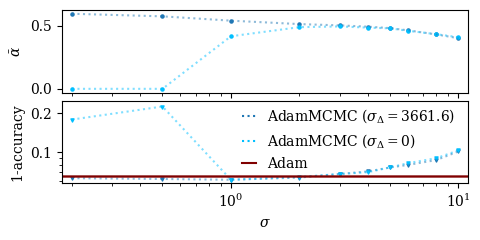

In [22]:
#############
### sigma ###
#############

fig_accept_all, ax_accept_all = plt.subplots(2,1, figsize = (5,2.5), sharex= 'col')

ax_accept = ax_accept_all[0]
ax_accu = ax_accept_all[1]

beta = 0.99
betas_adam = (beta, beta)
optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

sigmas = np.array([0.2,0.5,1.0,2.0,3.0,4.0,5.0,6.0,8.0,10.]) #np.array([0.01,0.05,0.1,0.2,0.5,1.0,2.0,5.0])
sigma_delta = sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom
x = sigmas

for i_sad, sigma_adam_dir in enumerate([sigma_delta, 0]):
    accept, accu_test = np.zeros(len(sigmas)), np.zeros(len(sigmas))

    for i_sg, sigma in enumerate(sigmas):
        offline_tb_temp = tb_helper_offline({"Acceptance_rate": project.steps_per_epoch*project.num_epochs+1},
                                            model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/')
        offline_tb_temp.load()

        accept[i_sg] = np.mean(np.clip(offline_tb_temp.scalars["Acceptance_rate"], 0, 1))

        path = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
        preds = np.load(path +"preds.npy")
        labels = np.load(path +"labels.npy")
        correct = (preds == labels).sum().item()

        accu_test[i_sg] = correct/len(preds)

    ax_accept.scatter(x, accept, s=5, color = sigma_colors[i_sad])
    ax_accept.plot(x, accept, linestyle = ':', alpha = 0.5, color = sigma_colors[i_sad])

    ax_accu.scatter(x, 1-accu_test, marker = 'v', s=5, color = sigma_colors[i_sad])
    ax_accu.plot(x, 1-accu_test, alpha = 0.5, color = sigma_colors[i_sad], linestyle=':')

ax_accu.hlines(1-accu_adam_test,0.9*min(x), 1.1*max(x), color = color_adam, label='testing time Adam', linewidth = 1.)
    
#ax_accept.set_xlabel(r"$\sigma$")
ax_accu.set_xlabel(r"$\sigma$")
#ax_accu[2].set_xticks(ticks=(1,2,3,4,5,6,7,8,9,10), labels=('1','2','3','4','5','6','7','8','9','10'))
#ax_accu[2].set_yticks(ticks=(0.06,0.07,0.08,0.09,0.1), labels=('0.06','0.07','0.08','0.09','0.10'))

for a in [ax_accept]:
    a.set_ylabel(r"$\bar{\alpha}$")
for a in [ax_accu]:
    a.set_ylabel("1-accuracy")
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim(None, 0.25)
    a.set_yticks(ticks = [0.09, 0.08, 0.07, 0.06], labels=["", "", "", ""], minor = True)
    a.set_yticks(ticks = [0.1, 0.2], labels=["0.1", "0.2"], minor = False)
    
#ax_accept.set_title("mean acceptance rate", position =(0.475, None))
#ax_accu.set_title("accuracy on test set")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=sigma_colors[0], lw=1.5, linestyle=':'),
                Line2D([0], [0], color=sigma_colors[1], lw=1.5, linestyle=':'),
                Line2D([0], [0], color=color_adam, lw=1.5, linestyle='-')]


ax_accu.legend(custom_lines, [f'AdamMCMC ($\sigma_\Delta = {sigma_delta}$)', r'AdamMCMC ($\sigma_\Delta = 0$)', 'Adam'],
                  frameon = False, loc = 'lower right', ncol = 1, handlelength = 1.)
ax_accu.set_xlim(0.9*min(x), 1.1*max(x))

fig_accept_all.tight_layout()
fig_accept_all.subplots_adjust(hspace=0.1)
fig_accept_all.savefig('./figs/02b_accuracy_accept_sigma.pdf')

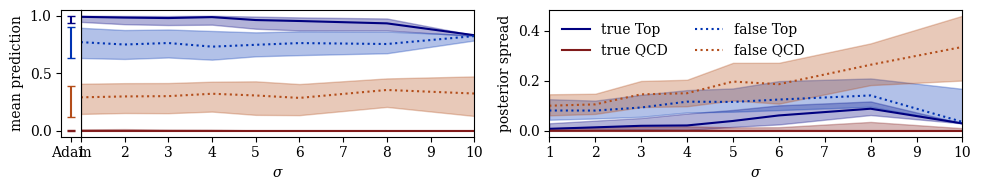

In [23]:
###################################
### Epsitemic uncertainty sigma ###
###################################

from scipy.special import softmax

beta = 0.99
betas_adam = (beta, beta)
optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

top_color_true, top_color_false = (0, 0, 0.5), (0, 0.2, 0.7) #RGB
qcd_color_true, qcd_color_false = (0.5, 0.1, 0.1), (0.7, 0.3, 0.1)

true_ls, false_ls = '-', ':'
color_adam = 'maroon'

min_plot_quant = 0.25
max_plot_quant = 0.75

epis_std = False
min_epis_quant = 0.25
max_epis_quant = 0.75

sigma_adam_dir_denom = 100
sigmas = np.array([1.0,2.0,3.0,4.0,5.0,6.0,8.0,10.]) #missing 0.2 and 0.5
x = sigmas

fig, ax = plt.subplots(1,2,figsize=(10,2))
divider = make_axes_locatable(ax[0])
ax_adam = divider.append_axes("left", size="5%", pad=0, sharey=ax[0])

for tag in ['true top', 'true qcd', 'false top', 'false qcd']:
    top_color = top_color_true if "true" in tag else top_color_false
    qcd_color = qcd_color_true if "true" in tag else qcd_color_false

    mean_pred, mean_epis = np.zeros((len(sigmas), 3)), np.zeros((len(sigmas), 3))
    for i_sg, sigma in enumerate(sigmas):
        sigma_adam_dir =  sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

        path = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
        preds = np.load(path +"preds.npy")
        labels = np.load(path +"labels.npy")
        scores_out = softmax(np.load(path +"logits_out.npy"), 1)

        mask = np.bitwise_and((preds == ('qcd' in tag)), (labels == (('qcd' in tag) == ('true' in tag))))
        
        if epis_std:
            pred = scores_out[mask].mean(2)[:,0]
            epis = scores_out[mask].std(2)[:,0]
        else:
            pred = np.median(scores_out[mask], 2)[:,0]
            epis = np.quantile(scores_out[mask],0.75,2)[:,0]-np.quantile(scores_out[mask],0.25,2)[:,0]
        
        mean_pred[i_sg] = np.quantile(pred, [min_plot_quant,0.5,max_plot_quant])
        mean_epis[i_sg] = np.quantile(epis, [min_plot_quant,0.5,max_plot_quant])

    #ax[0].errorbar(x, mean_pred[:,1], (mean_pred[:,1]-mean_pred[:,0], mean_pred[:,2]-mean_pred[:,1]), label = tag, capsize = 3,
    #               color = top_color if "top" in tag else qcd_color, linestyle = true_ls if 'true' in tag else false_ls,)
    #ax[1].errorbar(x, mean_epis[:,1],  (mean_epis[:,1]-mean_epis[:,0], mean_epis[:,2]-mean_epis[:,1]), label = tag, capsize = 3,
    #               color = top_color if "top" in tag else qcd_color, linestyle = true_ls if 'true' in tag else false_ls,)

    ax[0].plot(x, mean_pred[:,1], label = tag[:-3] + "Top" if "top" in tag else tag[:-3] + "QCD", 
                   color = top_color if "top" in tag else qcd_color, linestyle = true_ls if 'true' in tag else false_ls,)
    ax[1].plot(x, mean_epis[:,1], label = tag[:-3] + "Top" if "top" in tag else tag[:-3] + "QCD",
                   color = top_color if "top" in tag else qcd_color, linestyle = true_ls if 'true' in tag else false_ls,)
    ax[0].fill_between(x, mean_pred[:,0], mean_pred[:,2], alpha = 0.3,
                   color = top_color if "top" in tag else qcd_color)
    ax[1].fill_between(x, mean_epis[:,0], mean_epis[:,2], alpha = 0.3,
                   color = top_color if "top" in tag else qcd_color)
    
    path_adam =  model_path + f"/ParticleNet_adam_lr0.001_opt[('betas', '(0.99, 0.99)')]/"

    preds = np.load(path_adam +"preds.npy")
    labels = np.load(path_adam +"labels.npy")
    scores_out = softmax(np.load(path_adam +"logits.npy"), 1)
    mask = np.bitwise_and((preds == ('qcd' in tag)), (labels == (('qcd' in tag) == ('true' in tag))))

    mean_pred_adam = np.expand_dims(np.quantile(scores_out[mask][:,0], [0.25,0.5,0.75]),0)
    ax_adam.errorbar(0, mean_pred_adam[:,1], (mean_pred_adam[:,1]-mean_pred_adam[:,0], mean_pred_adam[:,2]-mean_pred_adam[:,1]), label = tag, capsize = 3,
                   color = top_color if "top" in tag else qcd_color, linestyle = true_ls if 'true' in tag else false_ls,)

ax[1].legend(loc = "upper left", ncols=2, frameon=False)

ax_adam.set_ylabel("mean prediction")
ax[1].set_ylabel("posterior spread") #"$75\%$-$25\%$ difference")
#ax[1].set_ylabel("epistemic uncertainty")

ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off)
ax_adam.set_xticks(ticks = [0], labels=["Adam"], minor = False)

for a in ax:
    a.set_xlabel(r"$\sigma$")
    a.set_xlim(1,10)
fig.tight_layout()
fig.savefig("./figs/03_uncertainty.pdf")

Text(0.5, 0.98, 'histogram of the last 500 losses')

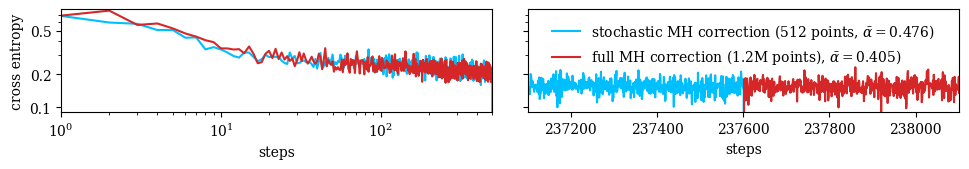

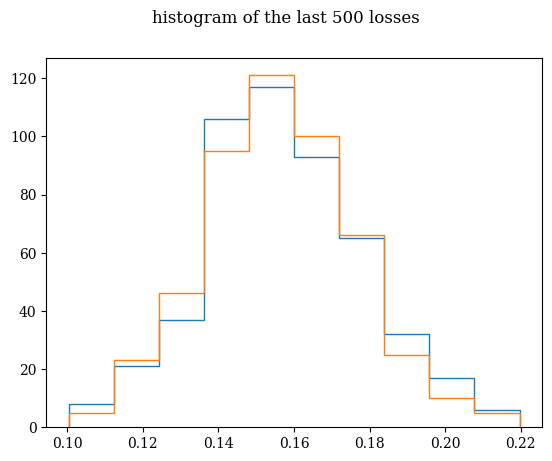

In [101]:
################################
### MH with the full dataset ###
################################

## losses

lr = 0.001
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
sigma = 0.2
sigma_factor = 1
betas_adam = (0.99,0.99)

optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

sigma_adam_dir_denom = 100
m_params = 366160
sigma_adam_dir =  m_params/sigma_adam_dir_denom

paths = [model_path + '/ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma2.0_sigmaadam3661.6_sigmafactor1',
         model_path +'ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma2.0_sigmaadam3661.6_sigmafactor1_full_loss',
         model_path + '/ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma2.0_sigmaadam3661.6_sigmafactor1_from98_full_loss',
         ]
      
plt_strs = ['AdamMCMC (lr = 1e-3, '+r'$\sigma = 2.0$)',
            'AdamMCMC full MH',
            'AdamMCMC full MH',
            ]
skips = [0]*len(paths)

colors = [ "deepskyblue", 
          "C3",
          "C3",
         ]

key = "/Loss/train"
i_k = 0

fig, ax = plt.subplots(1, 2, figsize=(10,1.8), sharey = True)
    
ax_log = ax[0]
ax_lin = ax[1]

for i_sg, (path, plt_str, skip, c) in enumerate(zip(paths, plt_strs, skips, colors)):
    y_plt = np.load(path + key + '.npy') 
    x_plt = np.arange(len(y_plt))
    if 'sgHMC' in plt_str and key == "/Loss/train":
        y_plt /= 1210999
    s = 2401

    if 'from' in path:
        x_plt += 2400*99+1

    if "test" in key:
        ax[i_k].plot(y_plt[skip:], label = plt_str, color = c, )
        ax[i_k].set_xlim(1,100)
    elif i_k ==0:
        bd = 500
        ax_log.plot(x_plt, y_plt[skip:], color = c)
        ax_log.set_xlim(1,bd)
        ax_log.set_xscale('log')
        ax_lin.plot(x_plt, y_plt[skip:], color = c, alpha =1, label = plt_str)
        ax_lin.set_xlim(2400*99+1-500, 2400*99+1+500)
        

accepts = [np.mean(np.clip(np.load(paths[0]+"/Acceptance_rate.npy")[99*2400-500:99*2400+2], 0, 1)),
          np.mean(np.clip(np.load(paths[1]+"/Acceptance_rate.npy")[:502], 0, 1)),
          ]


#ax_log.set_title('cross entropy loss on train set', x=1.1)
ax_log.set_ylabel('cross entropy')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=1.5, linestyle='-'),
                Line2D([0], [0], color=colors[1], lw=1.5, linestyle='-'),]

ax_lin.legend(custom_lines, [r'stochastic MH correction ($512$ points, $\bar{\alpha} = $' + f'{accepts[0]:.3})', 
                             r'full MH correction ($1.2$M points), $\bar{\alpha} = $' + f'{accepts[1]:.3})'],
                  frameon = False, loc = 'upper center', ncol = 1)

for a in ax:
    a.set_ylim(0.09,0.79)
    a.set_yscale('log')
    a.set_xlabel('steps')
    a.set_yticks([0.1,0.2,0.5,], labels = ['0.1','0.2','0.5'])
    a.set_yticks([0.3,0.4,0.6,0.7], labels = ['','','',''], minor =True)

fig.tight_layout()
fig_accept_all.subplots_adjust(hspace=0.1)
plt.savefig("./figs/04_full_MH.pdf")

fig, ax = plt.subplots(1,1)
_,b,_ = ax.hist(np.load(paths[0] + '/Loss/train.npy')[99*2400-502:99*2400], histtype = 'step')
ax.hist(np.load(paths[2] + '/Loss/train.npy')[:502], histtype = 'step', color = 'C1',bins=b)
fig.suptitle('histogram of the last 500 losses')